In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import pandas as pd
from mpl_toolkits.basemap import Basemap
import datetime

from src.feature_extraction import monthly_mean_TP as mm
from src.utils import modif_plot
from src.utils import save_name

# Import TOPAZ4-ML monthly mean

In [2]:
ifolder = '/scratch/project_465000269/edelleo1/Leo/results/lstm_231212-183758/ml/'
# ifolder = '/scratch/project_465000269/edelleo1/Leo/results/lstm_240405-180331/ml/'

ifile = 'sit_gLSTM3_bk_2011_2022_01.nc'
# ifile = 'sit_gLSTM3_bk_1998_2011_01.nc'

#ifile = 'sit_gLSTM3_bk_1999_2010_01.nc'


nc = nc4.Dataset(f'{ifolder}{ifile}', mode='r')

sit_ml = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_ml']
chrono = pd.DataFrame({'date':pd.to_datetime(sit_ml['time'].to_numpy())})

In [3]:
sit_fr = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_na']

## Import SIC

In [36]:
# import
ifolder = '/scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j150-629/'
ifile = 'siconc_TOPAZ4b23_2011_2022_FreeRun.nc'
nc = nc4.Dataset(f'{ifolder}{ifile}', mode='r')
sic_fr = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['siconc']

## Remove SIT if SIC < 15%

In [38]:
sic_fr

<xarray.DataArray 'siconc' (time: 4383, y: 479, x: 450)>
[944755650 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2022-12-31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -36.25 -36.12 -36.0 -35.88 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:   area: mean
    grid_mapping:   stereographic
    standard_name:  sea_ice_area_fraction
    units:          1

In [37]:
sit_ml2 = sit_ml.where((sic_fr>0.15))

KeyboardInterrupt: 

In [ ]:
sit_fr2 = sit_fr.where((sic_fr>0.15))

# Import CS2SMOS

In [4]:
cs_folder = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/CS2SMOS/results/'
cs_file = 'CS2SMOS_v205_20101101_20230415.nc'

In [5]:
nc = nc4.Dataset(f'{cs_folder}{cs_file}', mode='r')
sit_cs = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['analysis_sea_ice_thickness']
chrono_is = pd.DataFrame({'date':pd.to_datetime(sit_cs['time'].to_numpy())})

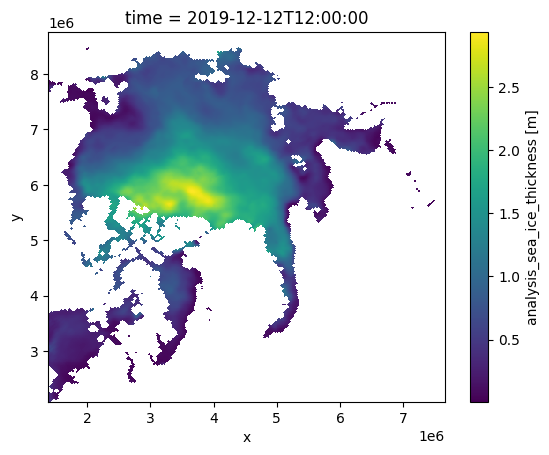

In [6]:
sit_cs.isel(time=1633).plot()

In [50]:
def draw_3basemap(sit_ml, sit_is, sit_en, sic_fr, day,
                  odir='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_ml       : Sea Ice Thickness from TOPAZ4-ML
        sit_is       : Sea Ice Thickness from ICESat 1
        sit_en       : Sea Ice Thickness from Envisat
        sic_fr       : Sea Ice Concentration from TOPAZ4-FR
        day          : datetime.date() object, first of the month to plot
    
    '''
    
    vmin = 0
    vmax = 4

    
     # identify index to plot for TOPAZ4-ML
    chrono = pd.DataFrame({'date':pd.to_datetime(sit_ml.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    tidx_ml = np.where(chrono_dt==day)[0]  
    
   # import pdb; pdb.set_trace()
    
    
    # identify index to plot for TOPAZ4-ML
    chrono = pd.DataFrame({'date':pd.to_datetime(sit_is.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    tidx_is = np.where(chrono_dt==day)[0]  
    
    # identify index to plot for TOPAZ4-ML
    chrono = pd.DataFrame({'date':pd.to_datetime(sit_en.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    tidx_en = np.where(chrono_dt==day)[0]  
    
    
    fig, axes = plt.subplots(ncols=3, figsize=(9*3, 9), constrained_layout=True)
    
    # -------------------------------------------------------------------------------
    
    
    m = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.fillcontinents(color='grey', lake_color='w')
    m.drawrivers(color='darkgrey')
    
    # sit_ml_ = sit_ml.isel(time=tidx_ml[0]).where(~np.isnan(sit_ml.isel(time=tidx_ml[0])), 0)
    
    mlons, mlats = m(sit_is.longitude, sit_is.latitude)    
    cs = m.pcolormesh(mlons, mlats, sit_ml.isel(time=tidx_ml[0]), vmin=vmin, vmax=vmax, **kwargs)
    #cs = m.pcolormesh(mlons, mlats, sit_ml_, vmin=vmin, vmax=vmax, **kwargs)
    

    axes[0].set_title('CS2SMOS')
    
    # -------------------------------------------------------------------------------
    
    
    m2 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    m2.fillcontinents(color='grey', lake_color='w')
    m2.drawrivers(color='darkgrey')
    
    sit_2_ = sit_is.isel(time=tidx_is[0]).where((sic_fr.isel(time=tidx_is[0])>0.15))
    
    mlons, mlats = m2(sit_is.longitude, sit_is.latitude)
    # m2.pcolormesh(mlons, mlats, sit_is.isel(time=tidx_is[0]), vmin=vmin, vmax=vmax, **kwargs)
    m2.pcolormesh(mlons, mlats, sit_2_, vmin=vmin, vmax=vmax, **kwargs)
    
    axes[1].set_title('TOPAZ4-FR')
    
    # -------------------------------------------------------------------------------
    
    
    m3 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[2])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    m3.fillcontinents(color='grey', lake_color='w')
    m3.drawrivers(color='darkgrey')
    
    sit_3_ = sit_en.isel(time=tidx_en[0]).where((sic_fr.isel(time=tidx_en[0])>0.15))
    
    
    mlons, mlats = m3(sit_en.longitude, sit_en.latitude)
    # m3.pcolormesh(mlons, mlats, sit_en.isel(time=tidx_en[0]), vmin=vmin, vmax=vmax, **kwargs)
    m3.pcolormesh(mlons, mlats, sit_3_, vmin=vmin, vmax=vmax, **kwargs)
    
    
    axes[2].set_title('TOPAZ4-RA')
    
    # -------------------------------------------------------------------------------
    
    
    cbar = fig.colorbar(cs, ax=axes[0], shrink=.8, location="bottom", extend='max', label='SIT (m)')
    cbar.ax.set_xticks([0,1,2,3,4])
    
    
    fig.suptitle(f'{day.strftime("%d %B %Y")}')
    modif_plot.resize(fig, s=24)
    
    if savefig:
        sdate = f'{day.strftime("%Y%m")}'
        ofile = f'SIT_CS2SMOS_TP4FR_TP4ML{sdate}.png'    
        plt.savefig(f"{odir}{ofile}", dpi=120, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()


# Plot

In [10]:
odir = '/scratch/project_465000269/edelleo1/Leo/intercomp/'

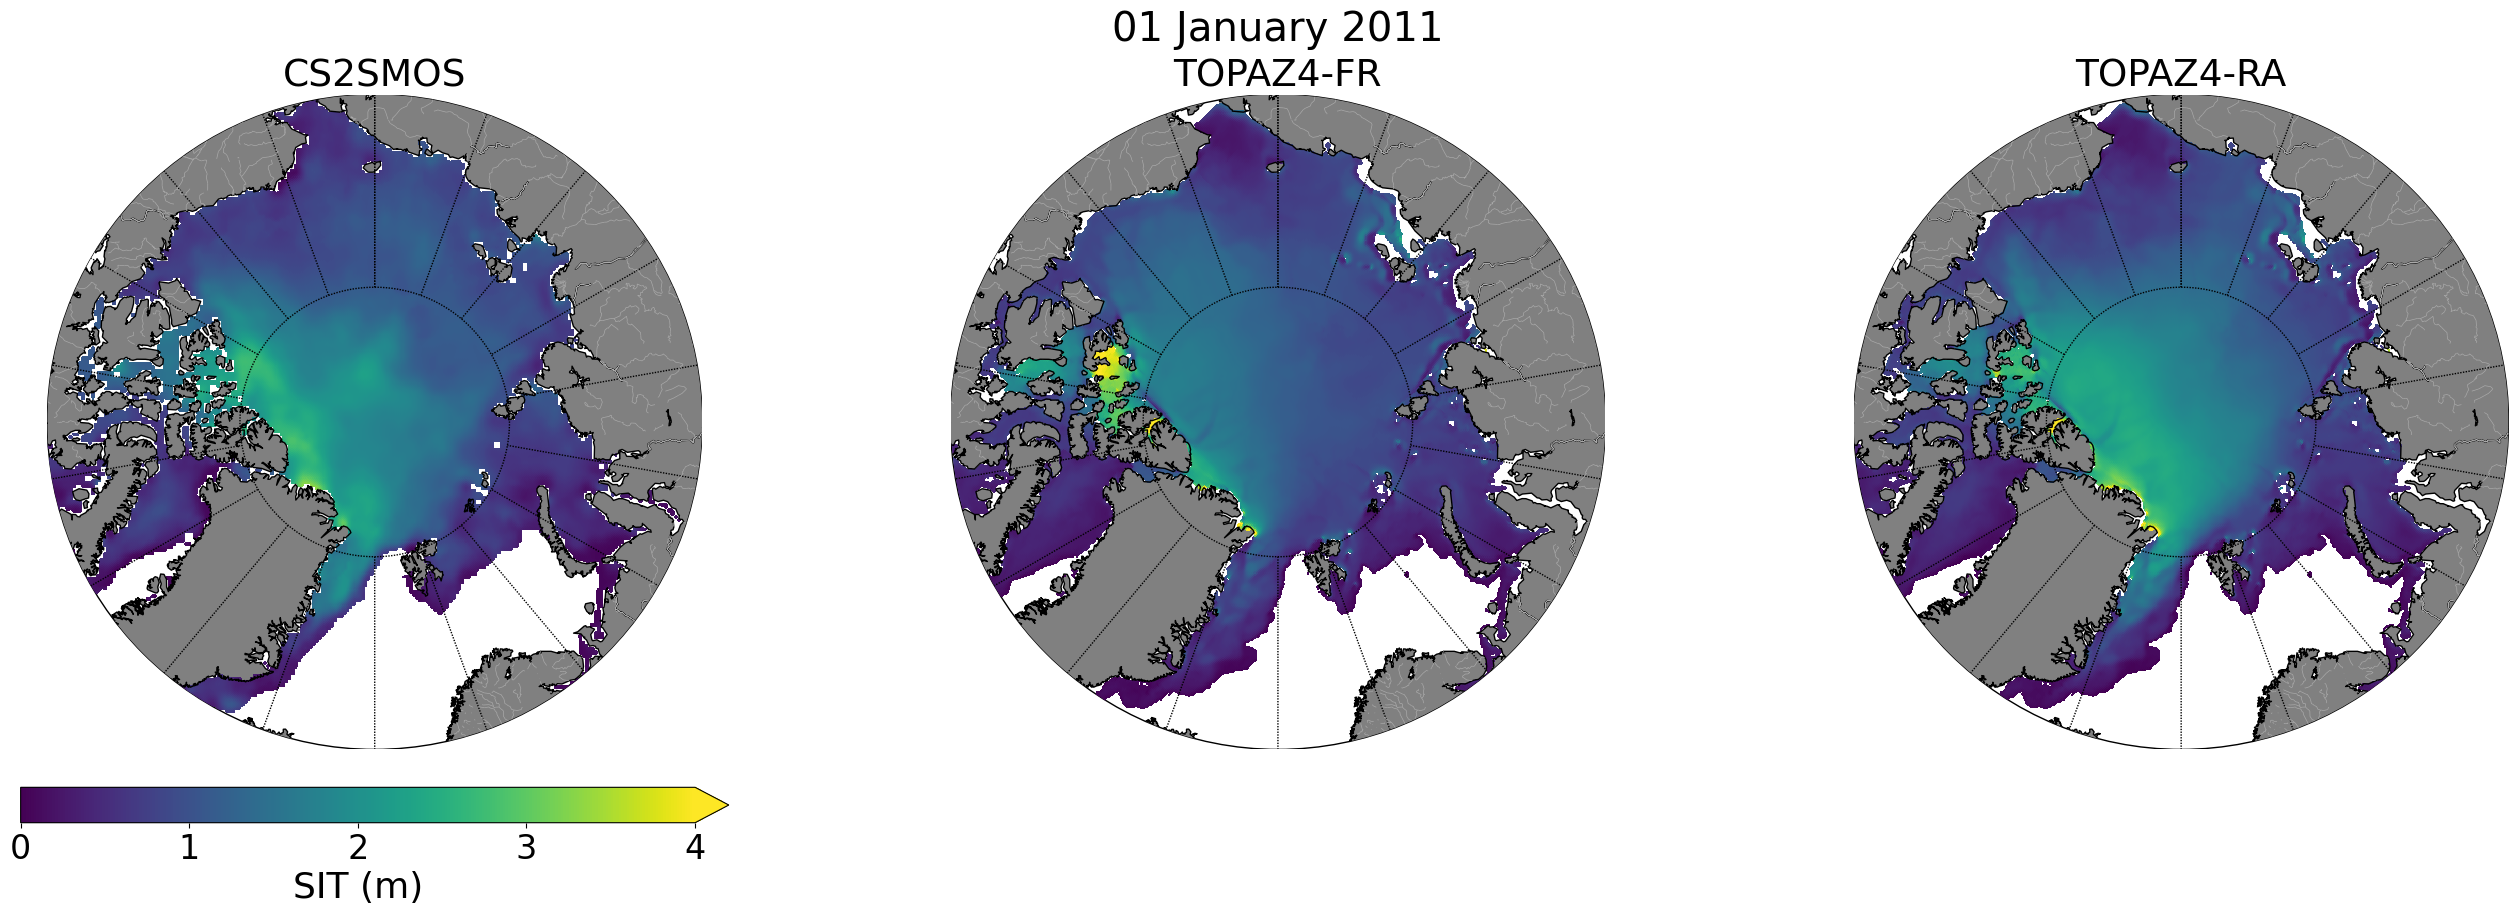

In [51]:
day = datetime.date(2011,1,1)
draw_3basemap(sit_cs, sit_fr, sit_ml, sic_fr,
              day, odir=odir, savefig=False)